In [25]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from data import load_env

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

from os import path
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

In [29]:
start_date = '2014-01-01'

# Understanding Data

In [51]:
env = load_env(parentdir, norm_state=False)
env.reset(date=start_date)
raw_X = env.data_df[:365]

## Plot curves of each column in raw data

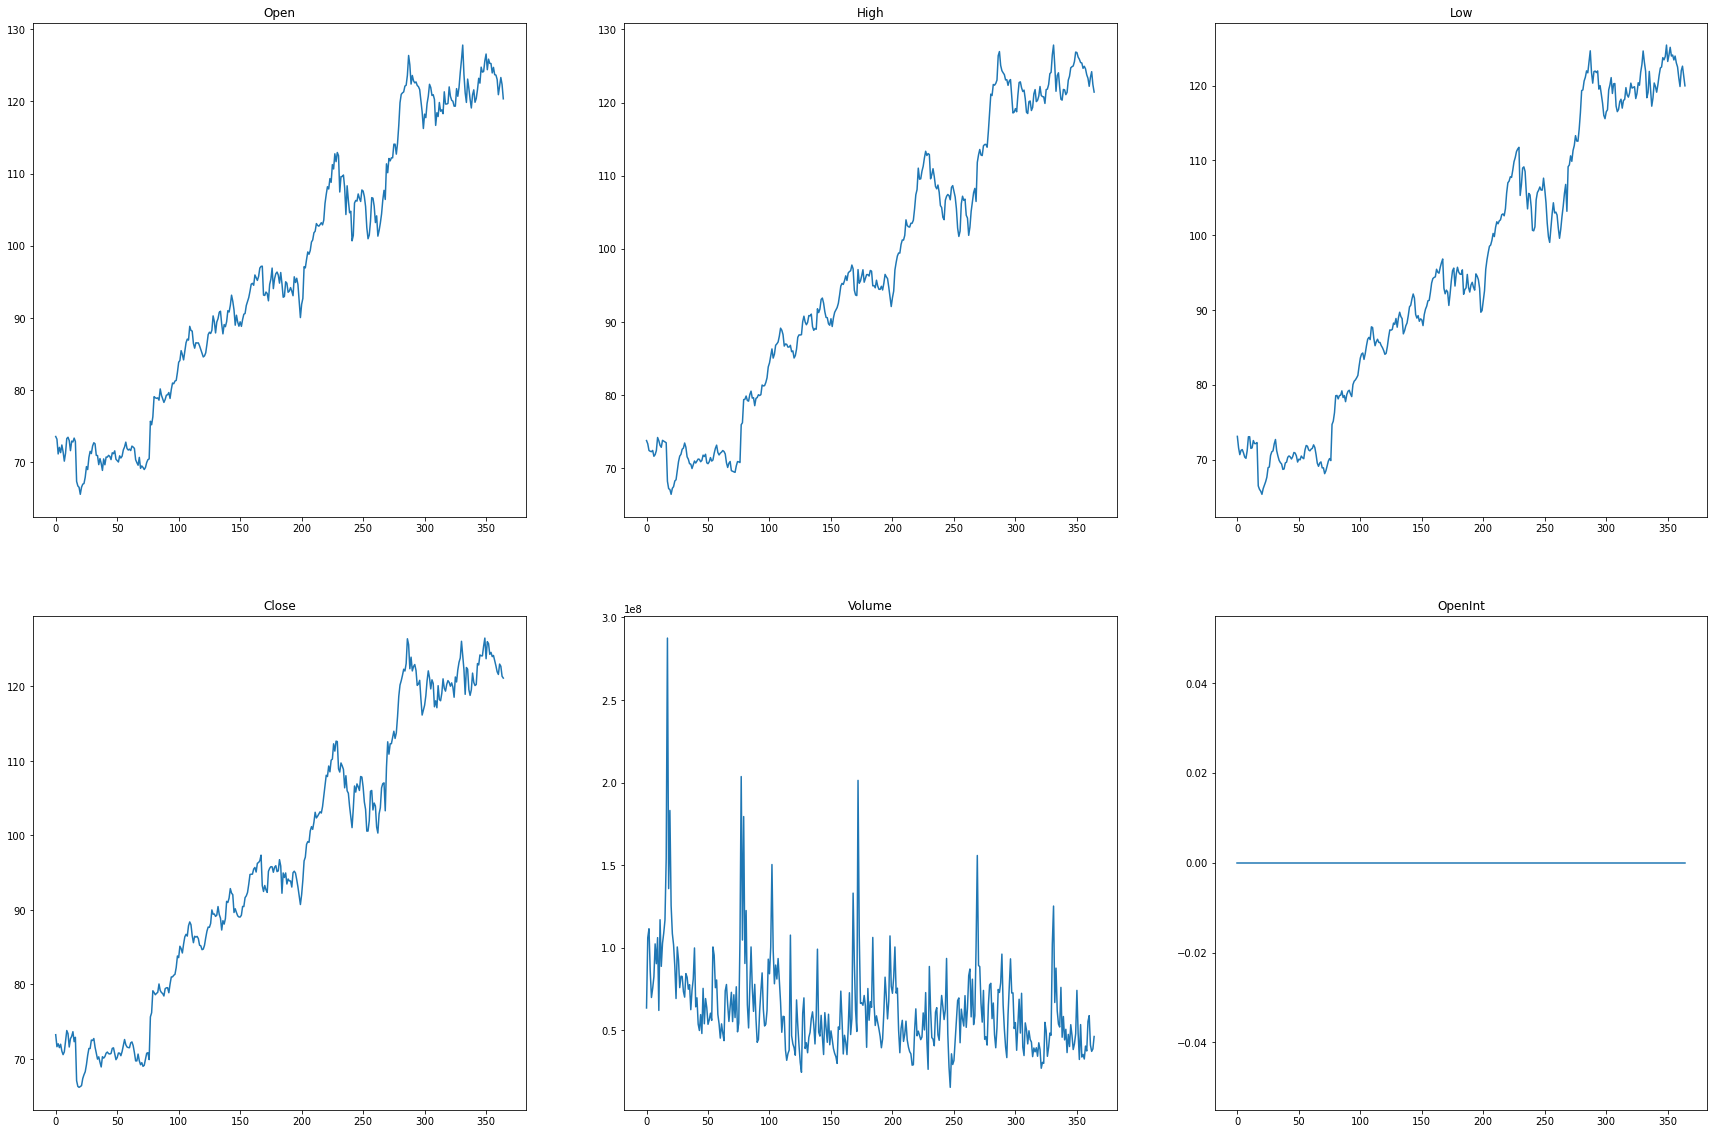

In [52]:
feature_names = list(raw_X.keys())

fig, axs = plt.subplots(nrows = 2, ncols=3, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):
    data_point = raw_X[col]
    ax.plot(list(data_point))
    
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel('')

In [54]:
env = load_env(parentdir)
env.reset(date="2014-01-01")
X = env.data_df[:365]

## Plot curves in each data column after preprocessing

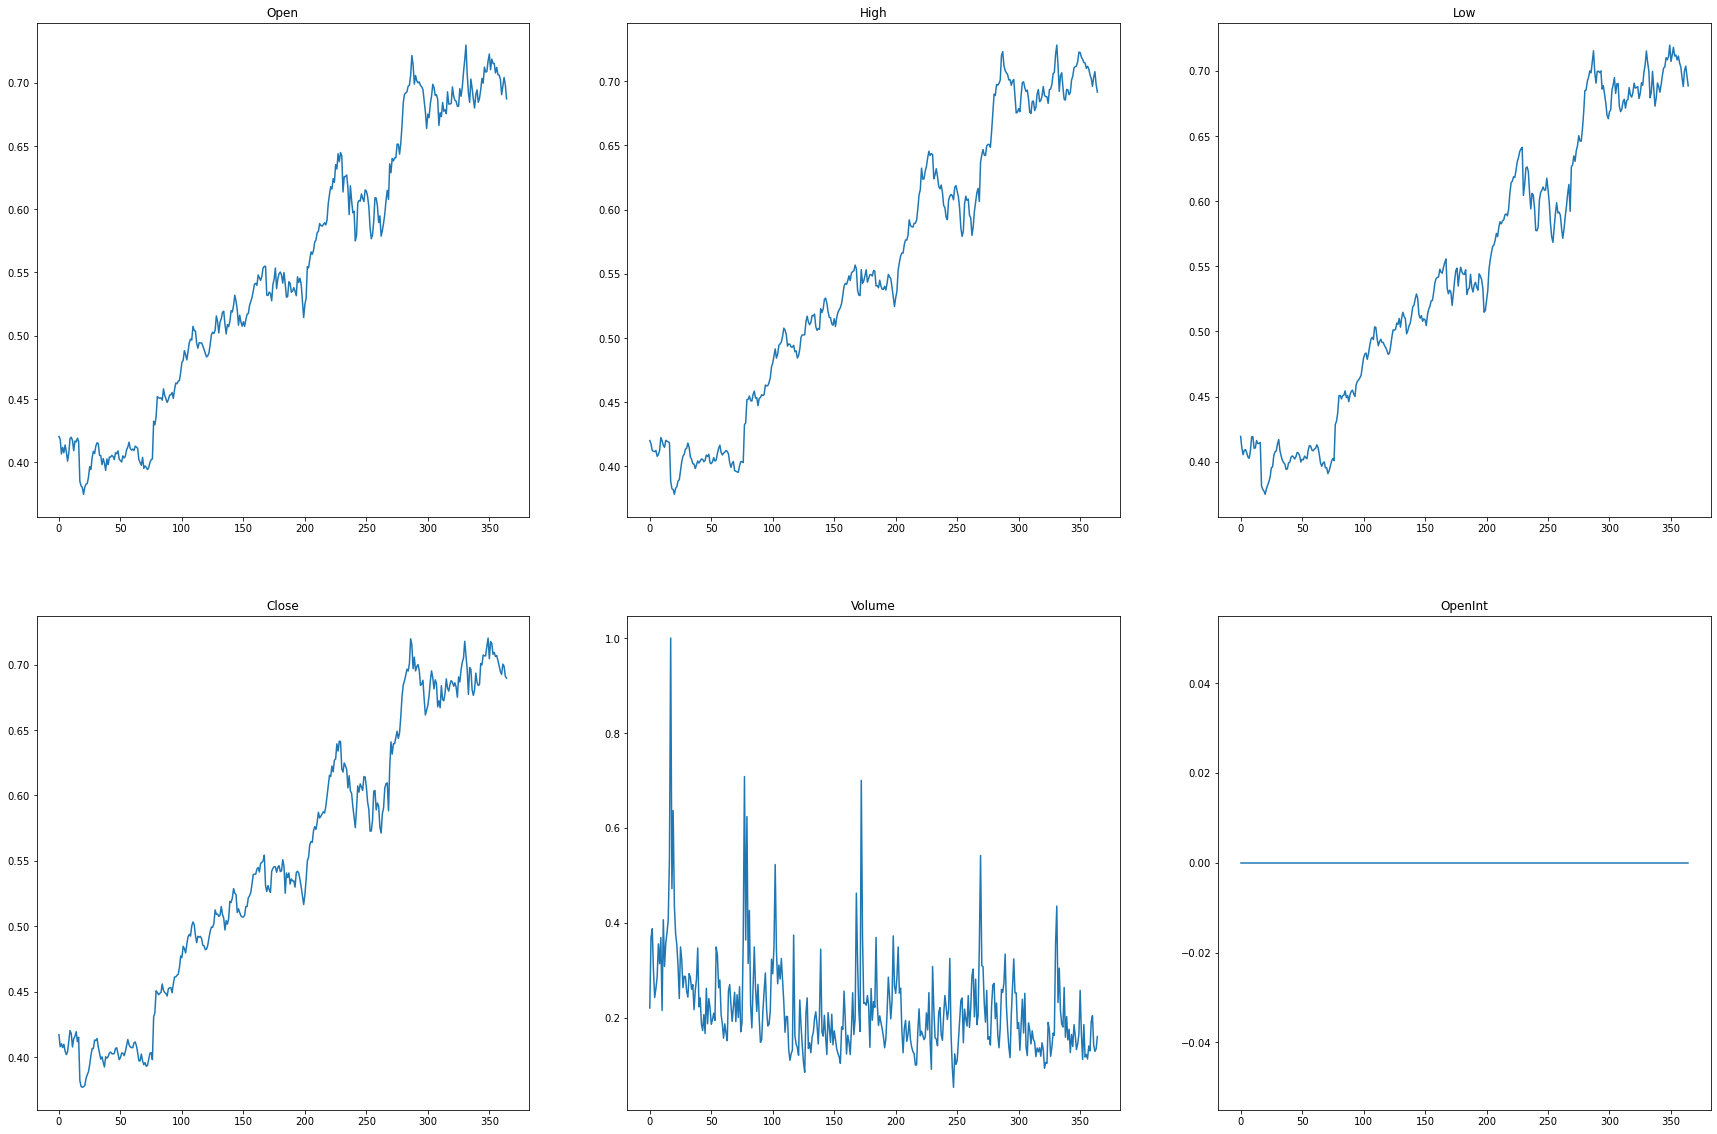

In [53]:
feature_names = list(X.keys())

fig, axs = plt.subplots(nrows = 2, ncols=3, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):
    data_point = X[col]
    ax.plot(list(data_point))
    
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel('')